In [36]:
df = df.drop(columns = ['Date','Time'],axis = 1)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas_datareader
from statsmodels.tsa.stattools import acf , pacf
import statsmodels.api as sm

In [7]:
df = pd.read_csv('data/dataset.csv', index_col=None)
df = df.dropna(axis = 0, how = 'all')
df_head = df.head(300).iloc[:,7:10]
print(df_head.shape)

(300, 3)


<AxesSubplot:>

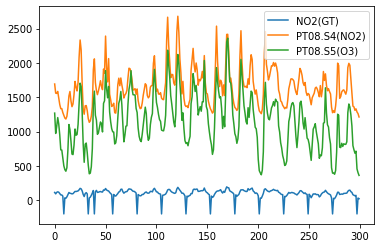

In [8]:
df_head.plot()

In [2]:
def get_arma_pq_params(single_ts):
    p,q = pq_calc(single_ts)
    p = p.tolist()
    q = q.tolist()
    if type(p)==list:
        p = max(p)
    if type(q)==list:
        q = max(q)
    if p == 0 and q == 0:
        p = 1
    return p,q

In [3]:
agg = series_to_supervised(df_head,df_head.columns)

NameError: name 'series_to_supervised' is not defined

In [ ]:
df_head

In [ ]:
agg

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf,q_stat, adfuller
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from scipy.stats import spearmanr, pearsonr,probplot, moment
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def stationarity_check(df,signif=0.05):
    non_stat_cols=[]
    for column in df.columns:
        ts = df[column]
        dftest = adfuller(ts, autolag='AIC')
        adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
        for key,value in dftest[4].items():
            adf['Critical Value (%s)'%key] = value
        p = adf['p-value']
        if p <= signif:
            stationarity = 1
        else:
            stationarity = 0
            non_stat_cols.append(column)
    return non_stat_cols



In [7]:
from fracdiff import Fracdiff, FracdiffStat, fdiff

<AxesSubplot:>

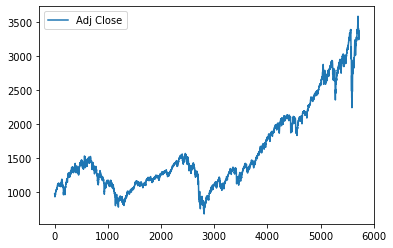

In [224]:
spx.plot()

-0.855
['Adj Close']
-0.145
['Adj Close']


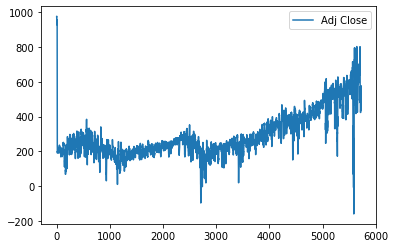

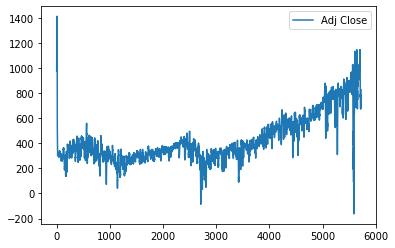

In [215]:
f = Fracdiff(-0.855,window =10)
X1 = pd.DataFrame(f.fit_transform(X.values),columns =X.columns)
print(f.d)
X1.plot()
non_stat_cols= stationarity_check(X1)
print(non_stat_cols)


f = Fracdiff(-0.145,window =10)
X2 = pd.DataFrame(f.fit_transform(X1.values),columns =X1.columns)
print(f.d)
X2.plot()
non_stat_cols= stationarity_check(X1)
print(non_stat_cols)

In [18]:
def make_stationary(df):
    df2 = df.copy()
    non_stat_cols= stationarity_check(df2)
    print("non_stat_cols",non_stat_cols)
    column_diff_dict = dict.fromkeys(non_stat_cols, 0)
    if len(non_stat_cols) != 0:
        for column in non_stat_cols:
            print(f"Column {column}")
            df2[column] = df2[column].diff(periods = 1)
            column_diff_dict[column]+=1
    else:
        return df2,column_diff_dict
    print("column_diff_dict ", column_diff_dict)
    return df2,column_diff_dict

In [8]:
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    print(dataframe)
    n = dataframe.shape[1] 
    pvalue_matrix = np.ones((n, n)) 
    keys = dataframe.columns 
    pairs = [] 
    for i in range(n):
        for j in range(i+1, n): 
            series1 = dataframe[keys[i]] 
            series2 = dataframe[keys[j]]
            result = sm.tsa.stattools.coint(series1, series2) 
            pvalue = result[1] 
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: 
                pairs.append((keys[i], keys[j], pvalue)) 
    integrated_columns = [] 
    for pair in pairs:
        integrated_columns.append(pair[0])
        integrated_columns.append(pair[1])
    integrated_columns=list(set(integrated_columns))
    return integrated_columns, pairs

In [9]:
from statsmodels.tsa.stattools import acf, q_stat, adfuller

In [10]:
import statsmodels.api as sm

In [11]:
def grangers_causation_matrix(data, variables, maxlag=40,test='ssr_chi2test', verbose=False): 
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1] 
    pvalue_matrix = np.ones((n, n)) 
    keys = dataframe.columns 
    pairs = [] 
    for i in range(n):
        for j in range(i+1, n): 
            series1 = dataframe[keys[i]] 
            series2 = dataframe[keys[j]]
            result = sm.tsa.stattools.coint(series1, series2) 
            pvalue = result[1] 
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: 
                pairs.append((keys[i], keys[j], pvalue)) 
    return pvalue_matrix, pairs

def get_pairs(df):
    pvalue_matrix, pairs = find_cointegrated_pairs(df)
    return pairs

In [12]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf,q_stat, adfuller
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from scipy.stats import spearmanr, pearsonr,probplot, moment
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [13]:
def invert_transformation(df_train, df_forecast, columns_diff_dict):
    df_fc = df_forecast.copy()
    columns = columns_diff_dict.keys()
    for col in columns:
        if col in df_fc.columns:   
            if columns_diff_dict[col]==2:
                df_fc[col] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[col].cumsum()
            df_fc[col] = df_train[col].iloc[-1] + df_fc[col].cumsum()
    return df_fc

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas_datareader
from statsmodels.tsa.stattools import acf , pacf
import statsmodels.api as sm
def param_calc(arr,alpha,nlags,nobs):
    var = np.ones(nlags + 1) / nobs
    var[0] = 0
    var[1] = 1. / nobs
    var[2:] *= 1 + 2 * np.cumsum(arr[1:-1]**2)
    interval = stats.norm.ppf(1 - alpha / 2.) * np.sqrt(var)
    count = 0
    max_count = 0
    for i in range(1,len(interval)):
        if arr[i]>interval[i] or arr[i]< - interval[i]:
            count+=1
        else:
            count = 0
        if count>max_count:
            max_count = count
    return max_count

def series_to_supervised(data, n_in=30,n_out= 2, predict=True):
    c_names = data.columns
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += ['%s(t-%d)' % (n, i) for n in c_names]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % n) for n in c_names]
        else:
            names += [('%s(t+%d)' % (n, i)) for n in c_names]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    test = agg.tail(1)
    agg.dropna(inplace=True)
    if predict:
        agg = agg.append(test,ignore_index=True)
    return agg

In [17]:
from statsmodels.tsa.arima_model import ARMA


In [27]:
a= pd.Series([1,2,3,4,5,6,7,8])

In [39]:
a.tail(len(b))

5    6
6    7
7    8
dtype: int64

In [29]:
b= pd.Series([1,2,3])

In [36]:
len(b)

3

In [40]:
b.reindex_like(a.tail(len(b)))

5   NaN
6   NaN
7   NaN
dtype: float64

In [35]:
b.reindex(new_index, fill_value=0)

NameError: name 'new_index' is not defined

In [18]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll import scope
from functools import partial
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [19]:

def pq_calc(ts):
    alpha = 0.05
    nobs  = len(ts)
    nlags = 40
    acf, _ = sm.tsa.acf(ts,nlags = nlags, alpha=alpha)
    pacf, _ = sm.tsa.pacf(ts,nlags = nlags, alpha=alpha)
    p = param_calc(pacf,alpha,nlags,nobs)
    q = param_calc(acf,alpha,nlags,nobs)
    return p,q

from statsmodels.tsa.holtwinters import ExponentialSmoothing

def residuals_add(train,train_columns,ma,predict):
    train = series_to_supervised(train,n_in = ma,predict = predict)
    resid_columns = ['ARIMA_'+str(column) for column in train_columns] + ['HWES_'+str(column) for column in train_columns]
    resid_df = pd.DataFrame(columns = resid_columns)
    for column in train_columns:
        p,q = pq_calc(train[column])
        i = 1
        model = ARIMA(train[column], order= (p,0,q))
        while True:
            try:
                model_fit = model.fit()
            except:
                i+=1
                p,q = p-1, q-1
                model = ARIMA(train[column], order= (p,0,q))
            else:
                break
        resid_df['ARIMA_'+str(column)] = model_fit.resid
        if resid_df['ARIMA_'+str(column)].isna().any():
            resid_df = resid_df.drop('ARIMA_'+str(column), axis = 1)
        model = ExponentialSmoothing(train[column])
        model_fit = model.fit()
        resid_df['HWES_'+str(column)] = model_fit.resid
        if resid_df['HWES_'+str(column)].isna().any():
            resid_df = resid_df.drop('HWES_'+str(column), axis = 1)
    train = pd.concat([train,resid_df],axis = 1)
    return train

def evaluate_metric(params,X_train,Y_train,max_evals,model):
    if params is not None:
        if type(model) is lightgbm.sklearn.LGBMRegressor:
            params['n_estimators'] = np.int(params['n_estimators'])
            params['num_leaves'] = np.int(params['num_leaves'])
        model.set_params(**params)
    model.set_params(**params)
    num_splits = 5
    rmse_score = 0
    kf = TimeSeriesSplit(n_splits=num_splits)
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        y_train, y_valid = pd.DataFrame(Y_train.iloc[train_index].copy()), pd.DataFrame(Y_train.iloc[test_index])
        x_train, x_valid = pd.DataFrame(X_train.iloc[train_index, :].copy()), pd.DataFrame(X_train.iloc[test_index, :].copy())
        fit_model = model.fit(x_train, y_train)
        pred = model.predict(x_valid)
        rmse_score += mean_squared_error(y_valid, pred)
        del y_valid, x_train, x_valid, y_train
    rmse_score/=num_splits
    return  {'loss': rmse_score, 'params': params,'status': STATUS_OK}

In [20]:
hyper_space_lgbm = {
    'learning_rate':    hp.uniform('learning_rate',0.001,0.1),
    'num_leaves':       hp.quniform('num_leaves', 31, 100, q=1),
    'min_split_gain':   hp.uniform('min_split_gain', 0, 1),
    'reg_alpha':        hp.uniform('reg_alpha',0,1),
    'reg_lambda':       hp.uniform('reg_lambda',0,1),
    'n_estimators':     hp.quniform('n_estimators', 100, 250, q=1)
}

import lightgbm
def train_test_split_func(X,y,size=0.25):
    train_x, val_x, train_y, val_y = train_test_split(X,y,test_size=size)
    return train_x, val_x, train_y, val_y


def get_best_params(X_train,Y_train,max_evals,model,hyper_space):
    trials = Trials()
    best_params = fmin( 
                fn=partial(evaluate_metric, X_train=X_train, Y_train=Y_train,max_evals=max_evals,model = model),
                space=hyper_space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials,
                rstate=np.random.RandomState(1),
                show_progressbar=True
            )
    return best_params

def cross_val_prediction(model,params,X_train,Y_train,X_test):
    n_splits = 5
    if params is not None:
        if type(model) is lightgbm.sklearn.LGBMRegressor:
            params['n_estimators'] = np.int(params['n_estimators'])
            params['num_leaves'] = np.int(params['num_leaves'])
        model.set_params(**params)
    num_splits = 5
    kf = TimeSeriesSplit(n_splits=num_splits)
    y_test_pred = pd.Series([0 for i in range(len(X_test))])
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        y_train, y_valid = pd.DataFrame(Y_train.iloc[train_index].copy()), pd.DataFrame(Y_train.iloc[test_index])
        x_train, x_valid = pd.DataFrame(X_train.iloc[train_index, :].copy()), pd.DataFrame(X_train.iloc[test_index, :].copy())
        fit_model = model.fit(x_train, y_train)
        pred = model.predict(X_test)
        y_test_pred += pred.squeeze()
        del y_valid, x_train, x_valid, y_train
    y_test_pred = y_test_pred / 5
    return y_test_pred

def train_valid_split(df,size=0.8):
    train = df[:int(size*(len(df)))]
    valid = df[int(size*(len(df))):]
    return train,valid
from lightgbm import LGBMRegressor



In [21]:
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import TimeSeriesSplit
from scipy import stats
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import cross_val_score

def boosting_prediction(df,train_columns,ma,steps,best_params):
    t1_columns = [column+str("(t+1)") for column in train_columns]
    t_columns = [column+str("(t)") for column in train_columns]
    train = residuals_add(df,t_columns,ma,predict= True)
    test = train.tail(1)
    train = train.dropna(axis = 0)
    prediction_df = pd.DataFrame()
    all_predicts = pd.DataFrame(columns = train_columns)
    for column in t1_columns:
        train_y = train[column]
        train_x = train.drop(t1_columns,axis = 1)
        test_y = test[column]
        test_x = test.drop(t1_columns,axis = 1)
        lgbm_model = LGBMRegressor()
        lgbm_predicts = cross_val_prediction(lgbm_model,best_params,train_x,train_y,test_x)
        column = column[:-5]
        prediction_df[column] = lgbm_predicts
    df = df.append(prediction_df,ignore_index=True)
    all_predicts = all_predicts.append(prediction_df,ignore_index=True)
    for i in range(steps-1):
        train = residuals_add(df,t_columns,ma,predict= True)
        test = train.tail(1)
        train = train.dropna(axis = 0)
        prediction_df = pd.DataFrame()
        for column in t1_columns:
            train_y = train[column]
            train_x = train.drop(t1_columns,axis = 1)
            test_y = test[column]
            test_x = test.drop(t1_columns,axis = 1)
            lgbm_model = LGBMRegressor()
            lgbm_predicts = cross_val_prediction(lgbm_model,best_params,train_x,train_y,test_x)
            column = column[:-5]
            prediction_df[column] = lgbm_predicts
        df = df.append(prediction_df,ignore_index=True)
        all_predicts = all_predicts.append(prediction_df,ignore_index=True)
    return all_predicts

from sklearn.ensemble import RandomForestRegressor
import catboost as cb
from sklearn.linear_model import LinearRegression
from collections import Counter

def get_best_ma(df,train_columns,valid_size):
    t1_columns = [column+str("(t+1)") for column in train_columns]
    t_columns = [column+str("(t)") for column in train_columns]
    best_rmse = np.inf
    best_ma = 0
    break_count = 0
    mas = np.arange(10,df.shape[0]//2,10)
    for ma in mas:
        train = residuals_add(df,t_columns,ma,predict= False)
        train, test = train_valid_split(train,valid_size)
        prediction_df = pd.DataFrame()
        kf = TimeSeriesSplit(n_splits=10)
        true_y = pd.DataFrame()
        for column in t1_columns[:1]:
            train_y = train[column]
            train_x = train.drop(t1_columns,axis = 1)
            test_y = test[column]
            test_x = test.drop(t1_columns,axis = 1)
            model = LGBMRegressor()
            pred = cross_val_prediction(model,None,train_x,train_y,test_x)
            mse = mean_squared_error(test_y, pred)
            if mse < best_rmse:
                best_rmse = mse
                best_ma = ma
                break_count = 0
            else:
                break_count+=1
            if break_count==3:
                break
    return best_ma

def boosting_validation(df,train_columns,valid_size):
    ma = get_best_ma(df,train_columns,valid_size)
    t1_columns = [column+str("(t+1)") for column in train_columns]
    t_columns = [column+str("(t)") for column in train_columns]
    train = residuals_add(df,t_columns,ma,predict= False)
    train, test = train_valid_split(train,valid_size)
    prediction_df = pd.DataFrame()
    true_y = pd.DataFrame()
    for column in t1_columns:
        train_y = train[column]
        train_x = train.drop(t1_columns,axis = 1)
        test_y = test[column]
        test_x = test.drop(t1_columns,axis = 1)
        lgbm_model = LGBMRegressor()
        lgbm_best_params = get_best_params(train_x,train_y,40,lgbm_model,hyper_space_lgbm)
        lgbm_predicts = cross_val_prediction(lgbm_model,lgbm_best_params,train_x,train_y,test_x)
        prediction_df[column] = lgbm_predicts
    return prediction_df,ma,lgbm_best_params

In [22]:
df = pd.read_csv('data/dataset.csv', index_col=None)
df = df.dropna(axis = 0, how = 'all')
df_head = df.head(300).iloc[:,7:10]

In [23]:
prediction_df,ma,best_params = boosting_validation(df_head,df_head.columns,0.8)

100%|██████████| 40/40 [00:11<00:00,  3.39trial/s, best loss: 77474.51452929534]


In [25]:
all_predicts=boosting_prediction(df_head,df_head.columns,ma,10,best_params)

<AxesSubplot:>

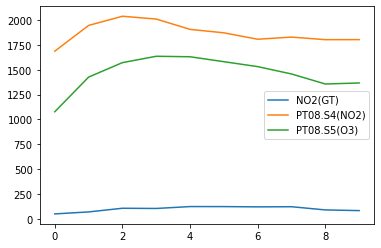

In [26]:
all_predicts.plot()

In [24]:
true_y.plot()
all_predicts.plot()

NameError: name 'true_y' is not defined

In [422]:
a = 'PT08.S5(O3)(t+1)'

In [424]:
a[:-5]

'PT08.S5(O3)'

In [8]:
t_columns = [column+str("(t)") for column in df_head.columns]
#train = residuals_add(df_head,t_columns,20,predict= False)

In [9]:
import statsmodels.api as sm

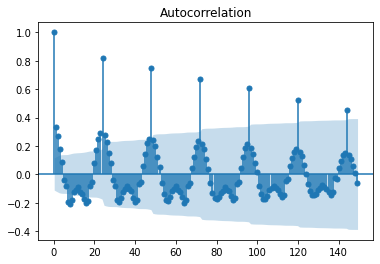

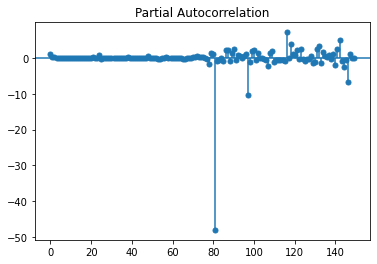

In [23]:
sm.graphics.tsa.plot_acf(df_head['NO2(GT)'], lags=25)
sm.graphics.tsa.plot_pacf(df_head['NO2(GT)'], lags=int((len(df_head['NO2(GT)'])/2 -1)))
plt.show()

In [10]:
print(1)

1


In [11]:
(len(df_head['NO2(GT)'])/2 -1)

,NO2(GT),PT08.S4(NO2),PT08.S5(O3)
0,113.0,1692.0,1268.0
1,92.0,1559.0,972.0
2,114.0,1555.0,1074.0
3,122.0,1584.0,1203.0
4,116.0,1490.0,1110.0
...,...,...,...
295,64.0,1309.0,684.0
296,70.0,1330.0,714.0
297,-200.0,1285.0,456.0
298,31.0,1261.0,401.0


In [51]:
df = df_head.head(10)
from sklearn.model_selection import train_test_split

In [53]:
train_x, val_x, train_y, val_y = train_test_split(df[['PT08.S4(NO2)','PT08.S5(O3)']],df['NO2(GT)'],test_size=0.2) 

In [54]:
train_x[]

,PT08.S4(NO2),PT08.S5(O3)
3,1584.0,1203.0
8,1276.0,620.0
1,1559.0,972.0
0,1692.0,1268.0
9,1235.0,501.0
2,1555.0,1074.0
4,1490.0,1110.0
5,1393.0,949.0


In [55]:
val_x

,PT08.S4(NO2),PT08.S5(O3)
6,1333.0,733.0
7,1333.0,730.0


In [56]:
df

,NO2(GT),PT08.S4(NO2),PT08.S5(O3)
0,113.0,1692.0,1268.0
1,92.0,1559.0,972.0
2,114.0,1555.0,1074.0
3,122.0,1584.0,1203.0
4,116.0,1490.0,1110.0
5,96.0,1393.0,949.0
6,77.0,1333.0,733.0
7,76.0,1333.0,730.0
8,60.0,1276.0,620.0
9,-200.0,1235.0,501.0
